In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
def preprocess_data(file_path):
    data = np.load(file_path)
    features = data['features']
    labels = data['labels']
    return features, labels

features, labels = preprocess_data('ohpRegressionDataset.npz')

In [3]:
print(features.shape)

(3040, 10)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class curlRegressionModel(nn.Module):
    def __init__(self, l1_lambda=0.01):
        super(curlRegressionModel, self).__init__()
        # define conv layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # define fc layers
        self.fc1 = nn.Linear(32 * 10, 128)  # 8 here is the number of features
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)  # single output for regression
        
        # batch norm layers
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(32)

        self.dropout = nn.Dropout(p=0.5)
        
        # L1 regularization
        self.l1_lambda = l1_lambda
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        # flatten output for fc layers
        x = x.view(-1, 32 * 10)  # 8 here is the number of features
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x

    def l1_regularization_loss(self):
        l1_loss = 0
        for param in self.parameters():
            l1_loss += torch.norm(param, p=1)
        return self.l1_lambda * l1_loss

In [5]:
model = curlRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

batch_size = 128

# create train dataloader
train_dataset_lstm = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size, shuffle=True)

# create test dataloader
test_dataset_lstm = TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val))
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size, shuffle=True)


In [6]:
# Step 6: Train the neural network
epoch_index = []
test_avg_mse = []
test_avg_abs_diff = []

best_mse = float('inf')
patience = 15
counter = 0
num_epochs = 1000

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader_lstm, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.view(-1, 1)
        
        # calculate loss
        loss = criterion(outputs, labels.float())
        l1_loss = model.l1_regularization_loss()
        total_loss = loss + l1_loss
        total_loss.backward()
        #loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print("Progress: ", "%0.2f" % ((epoch+1)/num_epochs*100),"%", end='\r')

    total_abs_diff = 0
    total_mse = 0
    num_samples = 0

    model.eval()
    with torch.no_grad():
        for data in test_loader_lstm:
            inputs, labels = data
            
            # forward pass for predictions
            outputs = model(inputs)
            # calculate MSE
            mse = torch.mean((outputs - labels.float()) ** 2)
            total_mse += mse.item() * inputs.size(0)
            
            # absolute difference
            abs_diff = torch.mean(torch.abs(outputs - labels.float()))
            total_abs_diff += abs_diff.item() * inputs.size(0)
            
            num_samples += inputs.size(0)
    
    avg_mse = total_mse / num_samples
    avg_abs_diff = total_abs_diff / num_samples
    
    test_avg_abs_diff.append(avg_abs_diff)
    test_avg_mse.append(avg_mse)
    epoch_index.append(epoch)
    
    # check for improvement in MSE
    if avg_mse < best_mse:
        best_mse = avg_mse
        counter = 0
    else:
        counter += 1
        
    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1} as validation MSE is not improving.')
        break
        
print('Finished Training')

Early stopping at epoch 36 as validation MSE is not improving.
Finished Training


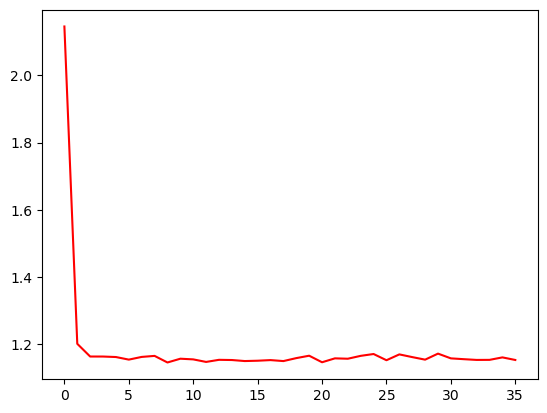

In [7]:
import matplotlib.pyplot as plt

plt.plot(epoch_index,  test_avg_abs_diff, color='red',)
plt.show()

In [8]:
model.eval()
with torch.no_grad():
    for data in test_loader_lstm:
        inputs, labels = data
        
        # forward pass for predictions
        outputs = model(inputs)
        # calculate absolute difference
        abs_diff = torch.mean(torch.abs(outputs - labels.float()))
        total_abs_diff += abs_diff.item() * inputs.size(0)
        
        num_samples += inputs.size(0)
        
    avg_abs_diff = total_abs_diff / num_samples

    print(avg_abs_diff)

1.1549688546281112


In [9]:
features, labels = preprocess_data('ohpRegressionDataset.npz')

batch_size = 32

# create dataloader
keypointsDataset = TensorDataset(torch.Tensor(features), torch.LongTensor(labels), )
keypoints_loader= DataLoader(keypointsDataset, batch_size=batch_size, shuffle=False)


all_outputs = []
all_labels = []

model.eval()
with torch.no_grad():
    for data in keypoints_loader:
        inputs, labels = data
        all_labels.extend(labels.tolist())
        
        # forward pass to get predictions
        outputs = model(inputs)
        all_outputs.extend(outputs.tolist())


all_outputs = [item for sublist in all_outputs for item in sublist]
all_outputs = [all_outputs[i:i+20] for i in range(0, len(all_outputs), 20)]

all_labels = [all_labels[i:i+20] for i in range(0, len(all_labels), 20)]

zipped_values = zip(all_outputs, all_labels)

all_scores_arr = []
all_labels_arr = []

for output, label in zipped_values:

    score = sum(output)/len(output)
    print("Label:", label[0], "Average:", score)
    all_scores_arr.append(score)
    all_labels_arr.append(label[0])

(3040, 10)
Label: 5 Average: 5.24759156703949
Label: 5 Average: 5.150196170806884
Label: 7 Average: 6.3987829208374025
Label: 7 Average: 6.360220575332642
Label: 6 Average: 6.147686290740967
Label: 6 Average: 6.137495660781861
Label: 7 Average: 6.422509098052979
Label: 7 Average: 6.257664465904236
Label: 6 Average: 6.19348509311676
Label: 7 Average: 6.267796111106873
Label: 6 Average: 6.240568518638611
Label: 5 Average: 6.002158284187317
Label: 5 Average: 5.29908607006073
Label: 6 Average: 6.27384467124939
Label: 5 Average: 6.164691400527954
Label: 6 Average: 6.1576536893844604
Label: 5 Average: 6.112174344062805
Label: 5 Average: 6.245400834083557
Label: 5 Average: 5.932439613342285
Label: 5 Average: 6.15058159828186
Label: 6 Average: 6.220526671409607
Label: 6 Average: 6.412301778793335
Label: 7 Average: 6.34547278881073
Label: 5 Average: 5.213887023925781
Label: 5 Average: 6.0857851028442385
Label: 7 Average: 6.344527077674866
Label: 7 Average: 6.137818670272827
Label: 7 Average: 6.

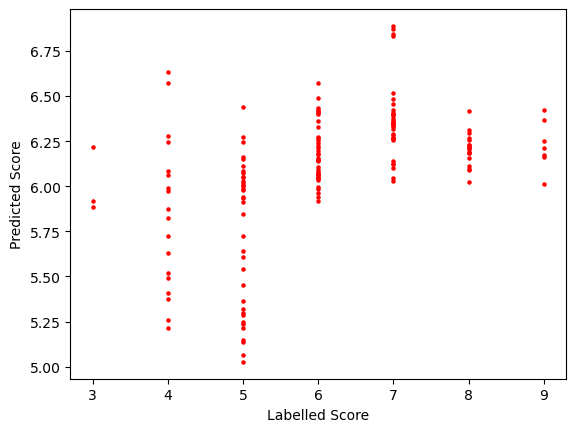

In [10]:
import matplotlib.pyplot as plt

plt.scatter(all_labels_arr,  all_scores_arr, color='red', s=5)
plt.xlabel('Labelled Score')
plt.ylabel('Predicted Score')
plt.show()

In [11]:
torch.save(model, 'curlRegressionModelTuned.pth')